In [20]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import Normalizer, StandardScaler, PowerTransformer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
import pandas as pd

In [2]:
%matplotlib inline

# Boston Housing Dataset with NN

In [3]:
from sklearn.datasets import load_boston
boston_data = load_boston()
boston_df = pd.DataFrame(boston_data.data, columns=boston_data.feature_names)
boston_df['MEDV'] = boston_data.target

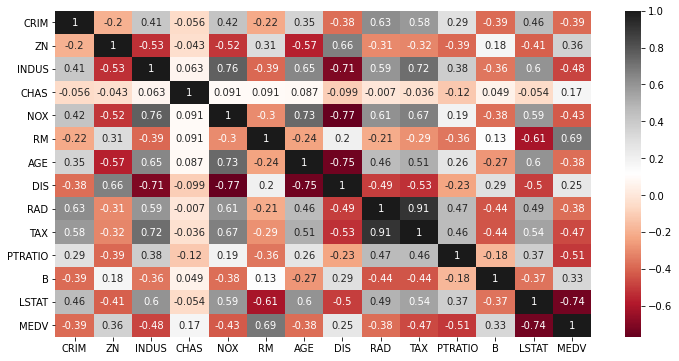

In [4]:
import seaborn as sns
corr_matrix = boston_df.corr().round(3)
fig3 =  plt.subplots(figsize=(12,6))
sns.heatmap(data=corr_matrix, annot=True, cmap = 'RdGy')
plt.show()

Predictors lowly-correlated with MEDV: **CHAS, DIS, B**

Predictors correlated with other predictors: **RAD**

In [5]:
boston_df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


In [6]:
X = boston_df.copy()
X.drop(['MEDV'], axis='columns', inplace=True)
#X.drop(['CHAS', 'DIS','B','RAD','MEDV'], axis='columns', inplace=True)
Y = boston_df['MEDV']

In [7]:
SC = StandardScaler()
pca_pipe = make_pipeline(SC, PCA())
pca_pipe.fit(X)

pca_model = pca_pipe.named_steps['pca']
PC = pd.DataFrame(data = pca_model.components_, columns = X.columns,
                  index = ['PC'+str(i+1) for i in range(13)])

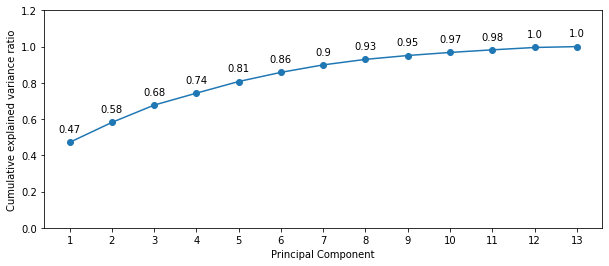

In [8]:
variance_cum = pca_model.explained_variance_ratio_.cumsum()
fig2, ax2 = plt.subplots(figsize=(10, 4))
x_pca = np.arange(13)+1
ax2.plot(x_pca, variance_cum, marker = 'o')

for x, y in zip(x_pca, variance_cum):
    label = round(y, 2)
    ax2.annotate(label, (x,y), textcoords="offset points", xytext=(0,10), ha='center')

ax2.set_ylim(0, 1.2)
ax2.set_xticks(x_pca)
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Cumulative explained variance ratio');

In [9]:
n=9
X_PC = pca_pipe.transform(X)
X_PC = pd.DataFrame(X_PC, columns = ['PC'+str(i+1) for i in range(13)], index = X.index)
X_PC.drop(X_PC.columns[[i for i in range(n,13)]],axis=1,inplace=True)

In [10]:
X_PC

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,-2.098297,0.773113,0.342943,-0.891774,0.423070,-0.315338,0.318641,0.295832,-0.424937
1,-1.457252,0.591985,-0.695199,-0.487459,-0.195876,0.264223,0.553861,-0.223670,-0.166962
2,-2.074598,0.599639,0.167122,-0.739204,-0.934534,0.448095,0.484560,0.105166,0.069775
3,-2.611504,-0.006871,-0.100284,-0.343721,-1.104956,0.664649,0.622641,0.255941,-0.342246
4,-2.458185,0.097712,-0.075348,-0.427907,-1.065924,0.617047,0.705086,-0.134524,-0.417668
...,...,...,...,...,...,...,...,...,...
501,-0.314968,0.724285,-0.860896,-0.434740,-1.121040,0.508064,0.199056,-0.249896,0.877036
502,-0.110513,0.759308,-1.255979,-0.309376,-0.891542,0.408208,0.191779,-0.146502,0.853628
503,-0.312360,1.155246,-0.408598,-0.786304,-1.595185,0.467947,0.294119,-0.638660,0.981032
504,-0.270519,1.041362,-0.585454,-0.678134,-1.416024,0.482259,0.271597,-0.579344,0.936755


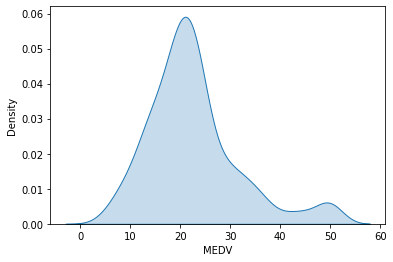

In [11]:
flow_distribution = sns.kdeplot(Y,shade=True)

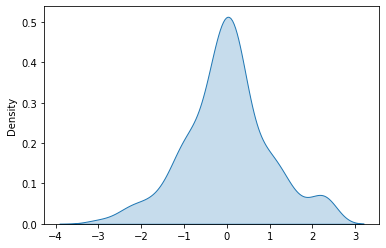

In [12]:
scaler = PowerTransformer(method='yeo-johnson', standardize=True)
scaler = scaler.fit(Y.to_numpy().reshape(-1, 1))
Y_SC = pd.Series(scaler.transform(Y.to_numpy().reshape(-1, 1)).reshape(-1))
flow_distribution2 = sns.kdeplot(Y_SC,shade=True)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_PC, Y_SC)

In [19]:
NN = MLPRegressor(learning_rate='adaptive', max_iter=5000)
params = {
    'activation': ['logistic', 'relu', 'tanh'],  # <-- added 'tanh' as third non-linear activation function
    'alpha': np.logspace(-4, 2, 7),
    'hidden_layer_sizes': [
        (10, 10), (20, 10), (30, 10),
        (40, 10), (90, 10), (100,100), (90, 30, 10),   # <-- added more neurons or layers
    ]
}
reg = GridSearchCV(estimator=NN, param_distributions=params, 
                         cv=3, refit=True, verbose=2,scoring = 'r2')  # <-- verbose=5
reg.fit(X_train, y_train)

c:\users\alanc\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 147 is smaller than n_iter=1000. Running 147 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 147 candidates, totalling 441 fits
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10); total time=   0.3s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10); total time=   0.6s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10); total time=   0.5s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(20, 10); total time=   0.1s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(20, 10); total time=   0.3s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(20, 10); total time=   0.4s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(30, 10); total time=   0.1s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(30, 10); total time=   0.4s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(30, 10); total time=   0.3s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(40, 10); total time=   0.2s
[CV] END activati

[CV] END activation=logistic, alpha=1.0, hidden_layer_sizes=(30, 10); total time=   0.4s
[CV] END activation=logistic, alpha=1.0, hidden_layer_sizes=(30, 10); total time=   0.3s
[CV] END activation=logistic, alpha=1.0, hidden_layer_sizes=(30, 10); total time=   0.5s
[CV] END activation=logistic, alpha=1.0, hidden_layer_sizes=(40, 10); total time=   0.4s
[CV] END activation=logistic, alpha=1.0, hidden_layer_sizes=(40, 10); total time=   0.3s
[CV] END activation=logistic, alpha=1.0, hidden_layer_sizes=(40, 10); total time=   0.1s
[CV] END activation=logistic, alpha=1.0, hidden_layer_sizes=(90, 10); total time=   0.3s
[CV] END activation=logistic, alpha=1.0, hidden_layer_sizes=(90, 10); total time=   0.3s
[CV] END activation=logistic, alpha=1.0, hidden_layer_sizes=(90, 10); total time=   0.3s
[CV] END activation=logistic, alpha=1.0, hidden_layer_sizes=(100, 100); total time=   0.5s
[CV] END activation=logistic, alpha=1.0, hidden_layer_sizes=(100, 100); total time=   0.3s
[CV] END activati

[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(90, 10); total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100); total time=   0.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100); total time=   0.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100); total time=   1.0s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(90, 30, 10); total time=   1.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(90, 30, 10); total time=   1.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(90, 30, 10); total time=   1.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(10, 10); total time=   0.2s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(10, 10); total time=   0.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(10, 10); total time=   0.3s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(20, 10); total time=   0.6s
[CV] END activation=relu, alp

[CV] END activation=relu, alpha=100.0, hidden_layer_sizes=(20, 10); total time=   0.5s
[CV] END activation=relu, alpha=100.0, hidden_layer_sizes=(20, 10); total time=   0.5s
[CV] END activation=relu, alpha=100.0, hidden_layer_sizes=(30, 10); total time=   0.5s
[CV] END activation=relu, alpha=100.0, hidden_layer_sizes=(30, 10); total time=   0.5s
[CV] END activation=relu, alpha=100.0, hidden_layer_sizes=(30, 10); total time=   0.4s
[CV] END activation=relu, alpha=100.0, hidden_layer_sizes=(40, 10); total time=   0.3s
[CV] END activation=relu, alpha=100.0, hidden_layer_sizes=(40, 10); total time=   0.2s
[CV] END activation=relu, alpha=100.0, hidden_layer_sizes=(40, 10); total time=   0.3s
[CV] END activation=relu, alpha=100.0, hidden_layer_sizes=(90, 10); total time=   0.3s
[CV] END activation=relu, alpha=100.0, hidden_layer_sizes=(90, 10); total time=   0.3s
[CV] END activation=relu, alpha=100.0, hidden_layer_sizes=(90, 10); total time=   0.3s
[CV] END activation=relu, alpha=100.0, hidd

[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(90, 10); total time=   0.3s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100, 100); total time=   0.6s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100, 100); total time=   0.5s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100, 100); total time=   1.0s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(90, 30, 10); total time=   0.8s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(90, 30, 10); total time=   1.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(90, 30, 10); total time=   0.8s
[CV] END activation=tanh, alpha=1.0, hidden_layer_sizes=(10, 10); total time=   0.4s
[CV] END activation=tanh, alpha=1.0, hidden_layer_sizes=(10, 10); total time=   0.5s
[CV] END activation=tanh, alpha=1.0, hidden_layer_sizes=(10, 10); total time=   0.4s
[CV] END activation=tanh, alpha=1.0, hidden_layer_sizes=(20, 10); total time=   0.4s
[CV] END activation=tanh, alpha=1.0, hidden_lay

RandomizedSearchCV(cv=3,
                   estimator=MLPRegressor(learning_rate='adaptive',
                                          max_iter=5000),
                   n_iter=1000,
                   param_distributions={'activation': ['logistic', 'relu',
                                                       'tanh'],
                                        'alpha': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                                        'hidden_layer_sizes': [(10, 10),
                                                               (20, 10),
                                                               (30, 10),
                                                               (40, 10),
                                                               (90, 10),
                                                               (100, 100),
                                                               (90, 30, 10)]},
                   scoring='r2', verbose=2)

In [21]:
reg.best_params_

{'hidden_layer_sizes': (90, 30, 10), 'alpha': 1.0, 'activation': 'relu'}

In [22]:
NN = MLPRegressor(max_iter=2000,activation = "relu", hidden_layer_sizes=(90,30,10), alpha = 1.0)
NN.fit(X_train,y_train)
NN_test = NN.predict(X_test)
NN_train = NN.predict(X_train)

In [23]:
print(r2_score(y_train, NN_train))
print(r2_score(y_test, NN_test))

0.9324448083619872
0.8607994691478289
